# POMDPs
## Timothy Devon Morris

A partially observable Markov decision process (POMDP) is a generalization of a Markov decision process (MDP). A POMDP models an agent decision process in which it is assumed that the system dynamics are determined by an MDP, but the agent cannot directly observe the underlying state. Instead, it must maintain a probability distribution over the set of possible states, based on a set of observations and observation probabilities, and the underlying MDP.

In this notebook, we will solve the POMDP presented in Thrun's Probabilistic Robotics P. 515 Figure 15.1.

In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [2]:
class POMDP(object):
    
    def __init__(self, P, R, Z, gam=1.):
        '''
        Constructor for POMDP class:
        P - Array (N_states, N_states, N_Actions)
            describes transition probabilities given actions
            next_state, prev_state, action. 
            (Terminal actions have probability 1 to return to themselves under all actions)
        R - Array (N_states, N_actions)
            rewards for state action pairs
        Z - Array (N_states, N_observations)
            measurement probabilities given states
        self.Ups - Constraints presented on the value function
            list of lists. Encodes linear function over belief space 
        '''
        self.P = P
        self.R = R
        self.Z = Z
        self.Ups = np.zeros((P.shape[0],1))
        self.Us = np.zeros((1))
        self.gam = gam
    
    def loop(self, T, plot=False):
        for t in xrange(T):
            # Lines 5-13
            # Value of prev_state, kth constraint, action u, measurement z
            v_jkuz = self.gam*np.einsum("ik,iz,iju->jkuz",self.Ups,self.Z,self.P)
            
            # Iterate through all possible combinations of constraints
            Ups = []
            Us = []
            for kz in itertools.product(np.arange(self.Ups.shape[1]), repeat=self.Z.shape[1]):
                Ups.append(self.R + np.einsum("ijkj->ik",v_jkuz[:,kz]))
                Us.append(np.arange(self.P.shape[2]))
                
            self.Ups = np.concatenate(Ups, axis=1)
            self.Us = np.concatenate(Us, axis=0)
            self.prune()
            if plot:
                self.plot(t)
        return self.Ups, self.Us
                
            
    def prune(self):
        # Quick pruning to remove redundant constraints
        self.Ups, idx = np.unique(self.Ups, axis=1, return_index=True)
        self.Us = self.Us[idx]
        
        # Pruning by finding the max for a list of possible probabilities
        # Note this only works in the case of 2 states and does not
        # generalize well to more complex state spaces
        s = []
        for p in np.linspace(0,1,num=100):
            s.append(np.argmax(p*self.Ups[0]+(1-p)*self.Ups[1]))
        
        self.Ups = self.Ups[:,s]
        self.Us = self.Us[s]
        # Once again remove redundant constraints
        self.Ups, idx = np.unique(self.Ups, axis=1, return_index=True)
        self.Us = self.Us[idx]
        
    def plot(self,t):
        fig = plt.figure(t)
        x = np.linspace(0,1, num=1000)
        y = np.max(np.outer(x,self.Ups[0])+np.outer(1-x,self.Ups[1]),axis=1)
        plt.plot(x,y)
        plt.title("Value of b after {} iterations".format(t+1))
        plt.xlim([0, 1])
        plt.ylim([-100, 100])
        plt.show()
        
            
        
                
    

In [3]:
P = np.zeros((3,3,3))
# Transition Probabilities between non-terminal states under various actions
P[0, 0, 2] = .2
P[1, 0, 2] = .8
P[1, 1, 2] = .2
P[0, 1, 2] = .8

# Transition Probabilities to and from terminal state
P[2, 0, 0] = 1.
P[2, 0, 1] = 1.
P[2, 1, 0] = 1.
P[2, 1, 1] = 1.
P[2, 2, 0] = 1.
P[2, 2, 1] = 1.
P[2, 2, 2] = 1.

# Reward function for state action pairs
R = np.zeros((3,3))
R[0, 0] = -100
R[0, 1] = 100
R[0, 2] = -1
R[1, 0] = 100
R[1, 1] = -50
R[1, 2] = -1

# Measurement probabilities for states
Z = np.zeros((3,3))
Z[0, 0] = 0.7
Z[0, 1] = 0.3
Z[1, 0] = 0.3
Z[1, 1] = 0.7
Z[2, 2] = 1.0

pomdp = POMDP(P,R,Z)

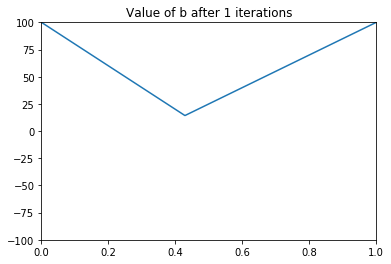

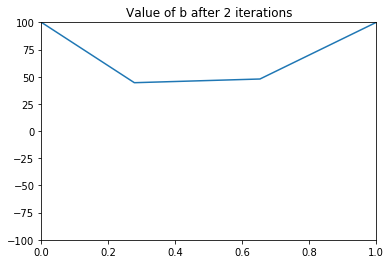

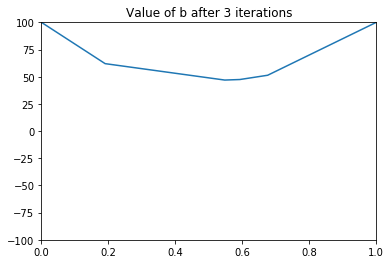

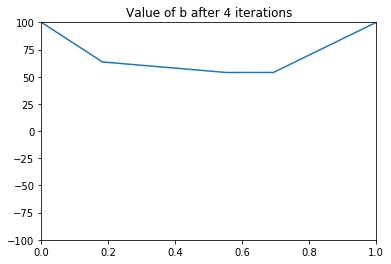

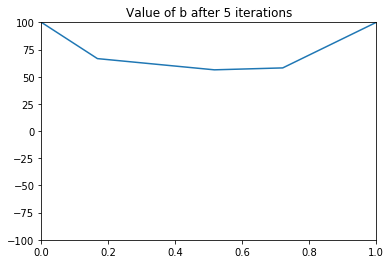

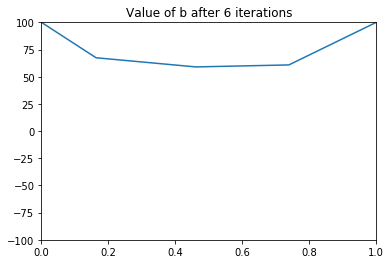

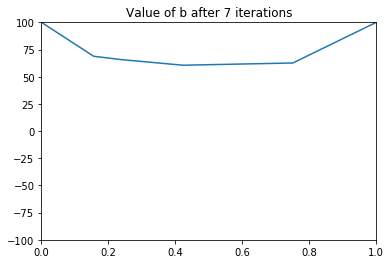

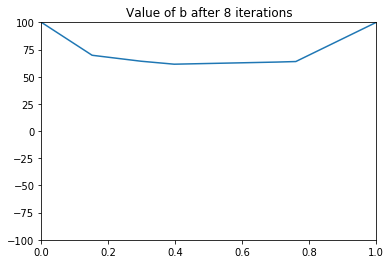

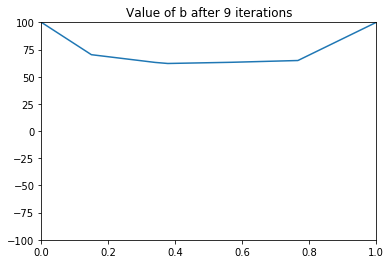

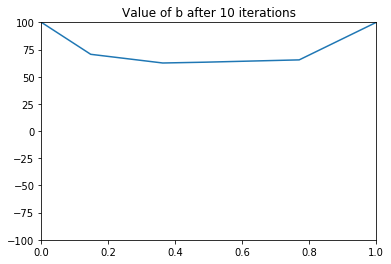

In [4]:
pomdp = POMDP(P,R,Z)
Ups, Us = pomdp.loop(10,plot=True)

In [12]:
for t in xrange(10):
    r = 0
    p = .6
    state = 0
    while state != 2:
        a = Us[np.argmax(p*Ups[0]+(1-p)*Ups[1])]
        r += R[state, a]
        state = np.random.choice(np.arange(3),p=P[:,state,a])
        p = 0.8 - 0.6*p
        m = np.random.choice(np.arange(3),p=Z[state,:])
        # Bayes Rule
        if m == 0:
            p = p*Z[0,0]/(p*Z[0,0]+(1-p)*Z[1,0])
        if m == 1:
            p = p*Z[0,1]/(p*Z[0,1]+(1-p)*Z[1,1])
    print r
        
    

98.0
98.0
94.0
98.0
98.0
85.0
85.0
94.0
-53.0
96.0
